In [11]:
import numpy as np
from scipy.io import loadmat
import tensorflow as tf
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline

#convert .mat data into ndarray and compress it usingle pickle
def mat_to_numpy(files,norm = True):
    print('Converting files ' + files[0] + ' to ' + files[-1])
    data = list()
    for idx, fl in enumerate(files):
        #open mat file
        mat = loadmat(fl)
        #convert from ndarray object to ndarray
        names = mat['dataStruct'].dtype.names
        ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
        #detect 100% drop-out, all data is zero
        if np.count_nonzero(ndata['data']) < 10:
            print('WARNING: 100% drop-out in file', fl)
            continue
        #detect if columns out of order
        if not all(x<y for x, y in zip(ndata['channelIndices'][0], ndata['channelIndices'][0][1:])):
            print('WARNING: Columns out of order in file' + fl)
        # Normalize data: axis = 0 is to normalize along columns, vertical lines.
        #todo: Is it ok to normalize or not?
        if(norm):
            data.append((ndata['data'] - np.mean(ndata['data'], axis=0))/np.std(ndata['data']))
    #convert list to ndarray
    return np.asarray(data)




Converting #1 files.
Converting ./datasets/train_1/1_9_1.mat ---->./datasets/train_1_tfr/1_9_1.tfr
2.8790910244


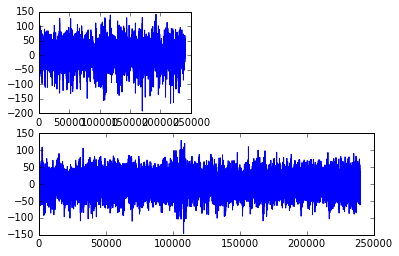

In [15]:

def mat2tfr(p_file):
    #converting mat file as numpy
    mat = loadmat(p_file)
    data = mat['dataStruct']['data'][0][0]


    #getting the filename and retrieving the patient, segement and label data
    pat, seg, label = p_file.split('/')[-1].split('.')[0].split("_")

    dstfolder = "./datasets/train_1_tfr/"
    dstfilename = dstfolder +pat+"_"+seg+"_"+label+".tfr"
    print("Converting " + p_file + " ---->" + dstfilename)

    #creating the TensorFlow Records 
    tfrwriter = tf.python_io.TFRecordWriter(dstfilename)
    
    plt.subplot(2,1,1)
    plt.plot(data[:,0])
    plt.subplot(2,1,2)
    plt.plot(data[:,1])
    plt.subplot(2,2,1)
    plt.plot(data[:,2])
    
    #reshape and transform to list due to TFRecords
    data = np.reshape(data, -1).tolist()

    #filling protobuff
    protobuf = tf.train.Example(
        features=tf.train.Features(feature={
            'label':  tf.train.Feature( 
                int64_list = tf.train.Int64List(value= [int(label)])),
            'data' :  tf.train.Feature(
                float_list=tf.train.FloatList(value= data))
    }))

    tfrwriter.write(protobuf.SerializeToString())
    tfrwriter.close()

        
        
        

def dataset2tfr(folder):
    filesinfolder = glob.glob(folder)
    print("Converting #%d files."%len(filesinfolder))
    
    for files in filesinfolder:
        t = time.time()
        
        mat2tfr(files)

        elapsed = time.time() - t
        print(elapsed)
        
        
dataset2tfr("./datasets/train_1/1_9_1.mat")
        

## Questions


    - Are all datasets 240000x16?
    - Do the 16 sensors in the same brain locations?
    - 